In [2]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
df_train=pd.read_csv("/content/hateval2019_en_train.csv")
df_test=pd.read_csv("/content/hateval2019_en_test.csv")
df_dev=pd.read_csv("/content/hateval2019_en_dev.csv")


In [5]:
tweet_df=pd.read_csv("/content/drive/MyDrive/ogbv/test.csv")
subset_df = tweet_df[tweet_df['language'].isin(['hi','en','ta'])]
df_eval = subset_df[subset_df['language'] == 'en']

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,7,12,16,18,33,38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df_train.drop(['TR', 'AG'], axis=1)
df_dev.drop(['TR', 'AG'], axis=1)
df_test.drop(['TR', 'AG'], axis=1)


,id,text,HS
0,34243,"@local1025 @njdotcom @GovMurphy Oh, I could ha...",0
1,30593,Several of the wild fires in #california and #...,0
2,31427,@JudicialWatch My question is how do you reset...,0
3,31694,"#Europe, you've got a problem! We must hurry...",1
4,31865,This is outrageous! #StopIllegalImmigration #...,1
...,...,...,...
2995,31368,you can never take a L off a real bitch😩 im ho...,1
2996,30104,@Brian_202 likes to call me a cunt & a bitch b...,1
2997,31912,@kusha1a @Camio_the_wise @shoe0nhead 1. Never ...,1
2998,31000,If i see and know you a hoe why would i hit yo...,1


In [7]:
df_train.rename(columns = {'HS':'label'}, inplace = True)
df_test.rename(columns = {'HS':'label'}, inplace = True)
df_dev.rename(columns = {'HS':'label'}, inplace = True)


In [8]:
#extract tweets and labels 
X_train=df_train.text.values
X_val=df_dev.text.values
X_test=df_test.text.values
X_eval=df_eval.tweet.values

y_train=df_train.label.values
y_val=df_dev.label.values
y_test=df_test.label.values

In [9]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [10]:
import nltk
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [11]:
import re
def remove_emojis(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

remove_emojis("Hilarious 😂! The feeling of making a sale 😎, The feeling of actually fulfilling orders 😒")

'Hilarious ! The feeling of making a sale , The feeling of actually fulfilling orders '

In [13]:
X_train_preprocessed1 = np.array([remove_emojis(text) for text in X_train])
X_val_preprocessed1 = np.array([remove_emojis(text) for text in X_val])
X_eval_preprocessed1 = np.array([remove_emojis(text) for text in X_eval])
X_test_preprocessed1 = np.array([remove_emojis(text) for text in X_test])


In [14]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train_preprocessed1])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val_preprocessed1])
X_eval_preprocessed = np.array([text_preprocessing(text) for text in X_eval_preprocessed1])
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test_preprocessed1])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)
X_eval_tfidf = tf_idf.transform(X_eval_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

CPU times: user 2min 18s, sys: 14.7 s, total: 2min 33s
Wall time: 2min 34s


In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

In [16]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    print(classification_report(y_true, y_pred))
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score

AUC: 0.8140
Accuracy: 73.40%
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       573
           1       0.72      0.61      0.66       427

    accuracy                           0.73      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.73      0.73      1000



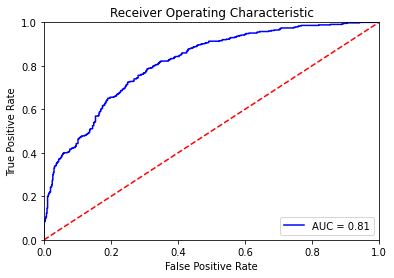

In [19]:
# Compute predicted probabilities for nb
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(nb_probs, y_val)


AUC: 0.6024
Accuracy: 52.23%
              precision    recall  f1-score   support

           0       0.74      0.27      0.40      1740
           1       0.46      0.87      0.60      1260

    accuracy                           0.52      3000
   macro avg       0.60      0.57      0.50      3000
weighted avg       0.62      0.52      0.48      3000



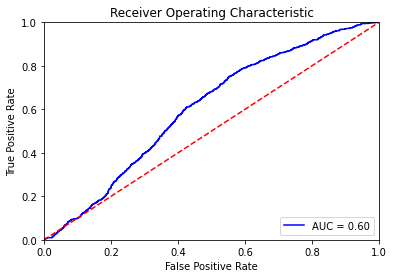

In [20]:
nb_probs = nb_model.predict_proba(X_test_tfidf)
evaluate_roc(nb_probs, y_test)


AUC: 0.8205
Accuracy: 74.40%
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       573
           1       0.70      0.69      0.70       427

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



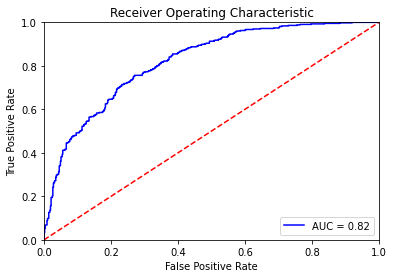

In [21]:
# Compute predicted probabilities for LG model
lg_model = LogisticRegression()
lg_model.fit(X_train_tfidf, y_train)
lg_probs = lg_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(lg_probs, y_val)

AUC: 0.6313
Accuracy: 48.83%
              precision    recall  f1-score   support

           0       0.80      0.16      0.26      1740
           1       0.45      0.95      0.61      1260

    accuracy                           0.49      3000
   macro avg       0.63      0.55      0.43      3000
weighted avg       0.65      0.49      0.41      3000



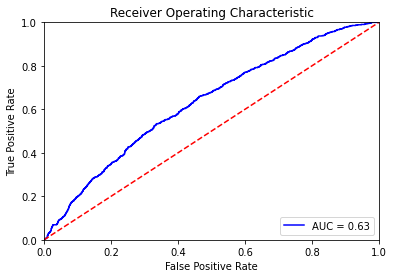

In [22]:
lg_probs = lg_model.predict_proba(X_test_tfidf)
evaluate_roc(lg_probs, y_test)


AUC: 0.8064
Accuracy: 72.80%
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       573
           1       0.74      0.56      0.64       427

    accuracy                           0.73      1000
   macro avg       0.73      0.71      0.71      1000
weighted avg       0.73      0.73      0.72      1000



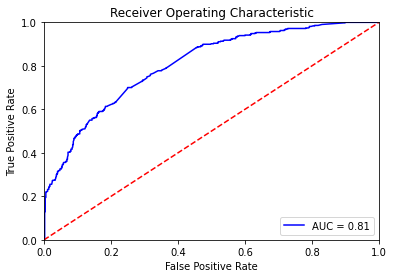

In [23]:
# Compute predicted probabilities for gradient boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_tfidf, y_train)
gb_probs = gb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(gb_probs, y_val)

AUC: 0.5361
Accuracy: 45.10%
              precision    recall  f1-score   support

           0       0.67      0.10      0.18      1740
           1       0.43      0.93      0.59      1260

    accuracy                           0.45      3000
   macro avg       0.55      0.52      0.38      3000
weighted avg       0.57      0.45      0.35      3000



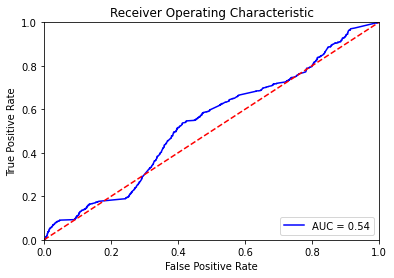

In [24]:
gb_probs = gb_model.predict_proba(X_test_tfidf)
evaluate_roc(gb_probs, y_test)


AUC: 0.8036
Accuracy: 72.20%
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       573
           1       0.67      0.69      0.68       427

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



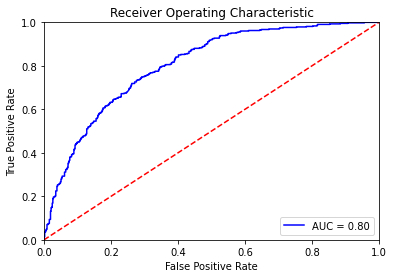

In [25]:
#svc
svc_model = SVC(probability= True, C=0.01, kernel="rbf")  # default rbf
svc_model.fit(X_train_tfidf, y_train)
svc_probs = svc_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(svc_probs, y_val)


AUC: 0.5865
Accuracy: 44.23%
              precision    recall  f1-score   support

           0       0.71      0.06      0.12      1740
           1       0.43      0.96      0.59      1260

    accuracy                           0.44      3000
   macro avg       0.57      0.51      0.36      3000
weighted avg       0.59      0.44      0.32      3000



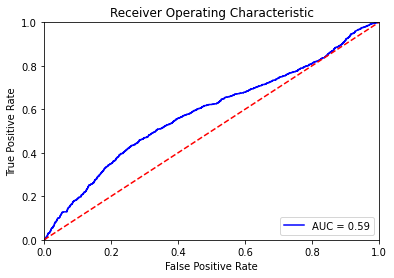

In [26]:
svc_probs = svc_model.predict_proba(X_test_tfidf)
evaluate_roc(svc_probs, y_test)


In [27]:
#eval hateeval
probs_eval_nb = nb_model.predict_proba(X_eval_tfidf)
probs_eval_lg= lg_model.predict_proba(X_eval_tfidf)
probs_eval_gb= gb_model.predict_proba(X_eval_tfidf)
probs_eval_svc = svc_model.predict_proba(X_eval_tfidf)

In [28]:
def Extract(lst):
    return [item[1] for item in lst]

In [29]:
list1 = probs_eval_nb.tolist()
list2= probs_eval_lg.tolist()
list3=  probs_eval_gb.tolist()
list4= probs_eval_svc.tolist()
list5=Extract(list1)
list6=Extract(list2)
list7=Extract(list3)
list8=Extract(list4)

In [30]:
df_eval['hateeval_nb'] = list5
df_eval['hateeval_lg'] = list6
df_eval['hateeval_gb'] = list7
df_eval['hateeval_svc'] = list8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [31]:
df_eval_hateeval_ml=df_eval[['_id', 'tweet','hateeval_nb','hateeval_lg', 'hateeval_gb' ,'hateeval_svc']]


In [32]:
df_eval_hateeval_ml

,_id,tweet,hateeval_nb,hateeval_lg,hateeval_gb,hateeval_svc
2,61e270a94cffadb7b4380238,@Nanditasweta please check your email now...,0.385686,0.320757,0.408327,0.442474
3,61e135862c3ddf2851d0f936,@kainaatarora @HRMusikLimited Awesome! Thanks...,0.339045,0.349728,0.408327,0.341494
4,61e12145ce28130593ebc8ad,@Tweet2Rhea 's brother #ShowikChakraborty has ...,0.146821,0.094692,0.172628,0.116632
5,61e1155c1cf48a3db760ca4b,@neerubajwa @IIMusic3 @ParmodSharmaDir #sawanr...,0.443378,0.229708,0.180894,0.234671
7,61e13f8c1c69f86aff676092,@IamDeepaMehta Deeepa!! You make this journey ...,0.232907,0.254021,0.365031,0.330524
...,...,...,...,...,...,...
114637,61d5edf77b77dfb5f288c6b2,@seemagoswami That’s a wrong statement Seema. ...,0.528664,0.579366,0.572879,0.559721
114639,61e13d775b61a506821c0054,@AyonikaPaul congrats for Olympic Quota 2016 @...,0.344727,0.353037,0.408327,0.411995
114640,61d617237b77dfb5f28940af,@jagishaarora @iamhumayunsaeed @adnanactor You...,0.279293,0.332258,0.408327,0.392448
114643,61e3b7a54270b50ae20a42bc,@RJDixita Perfect headshot... Thank you Hydera...,0.254369,0.208376,0.365031,0.263781


In [33]:
df_eval_hateeval_ml.to_csv("tfidf_ml_hateeval.csv")